In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model
import seaborn as sns
sns.set_theme()

import datetime

import warnings
warnings.filterwarnings('ignore')

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl



* Закидываем данные в обычную модель ARIMA


aic: 1419.41511 | order: (0, 2, 1)
Results of Dickey-Fuller Test:
Test Statistic                -1.297237e+01
p-value                        3.062128e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


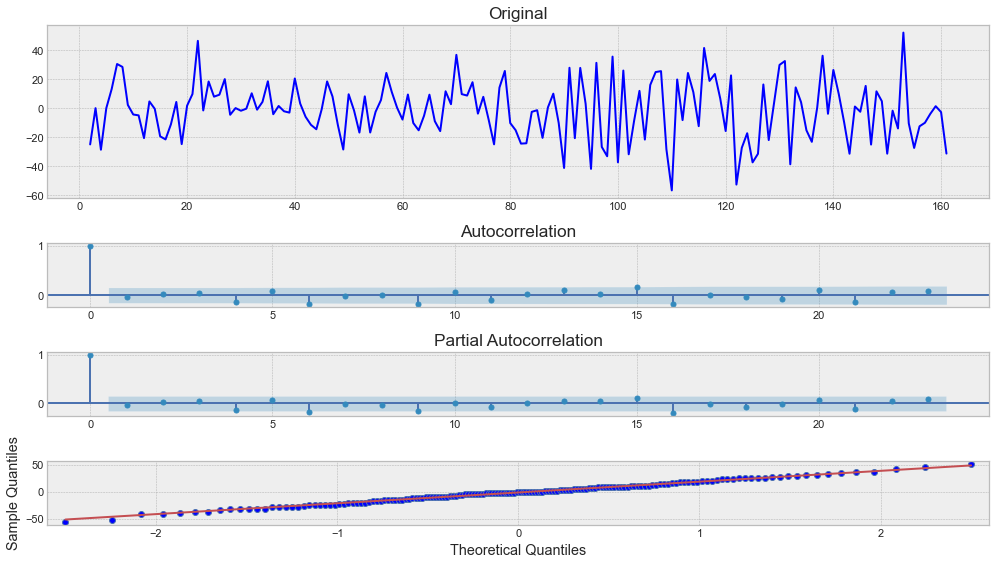

In [5]:
ts = pd.read_csv('weekly-closings-of-the-dowjones-.csv')
aic, order, mdl = _get_best_model(ts['Close'])
tsplot(mdl.resid)

* Наверно можно сказать, что дисперсия шума несколько расширяется с течением времени, посмотрим на нее отдельно

0.4844897137539944

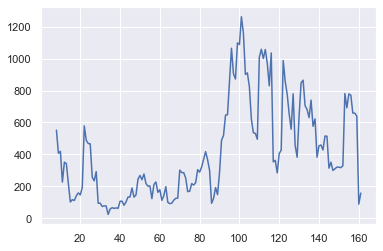

In [6]:
pd.Series(mdl.resid).rolling(7).var().plot()
adfuller(pd.Series(mdl.resid).rolling(7).var().dropna(), autolag='AIC')[1]

* Скорее всего имеет мысто нестабильность дисперсии, поэтому посмотрим на модель GARCH на этих же данных
* Перед этим проведем процедуры невилирования тренда и сезонности

<AxesSubplot:>

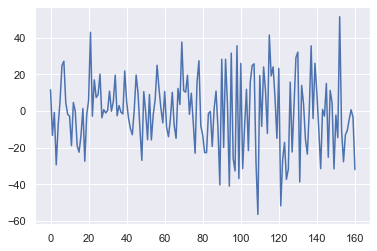

In [7]:
tss = ts['Close'].copy()
tss = np.diff(tss)
pd.Series(tss).plot()

<AxesSubplot:>

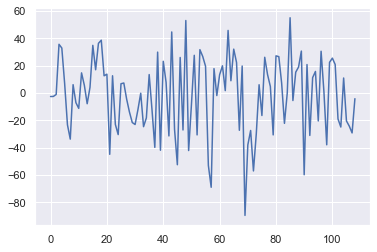

In [8]:
seasion = tss[:-52]
tss = tss[52:] - seasion
tss = pd.Series(tss)
tss.plot()

In [9]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(tss, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     42,   Neg. LLF: 517.8365798931718
Iteration:     10,   Func. Count:     77,   Neg. LLF: 517.6199523202886
Iteration:     15,   Func. Count:    112,   Neg. LLF: 517.1370754214056
Iteration:     20,   Func. Count:    147,   Neg. LLF: 516.7879666972862
Iteration:     25,   Func. Count:    186,   Neg. LLF: 516.76397917549
Iteration:     30,   Func. Count:    221,   Neg. LLF: 516.5381865022839
Iteration:     35,   Func. Count:    266,   Neg. LLF: 516.507169942058
Iteration:     40,   Func. Count:    302,   Neg. LLF: 516.504653856161
Optimization terminated successfully    (Exit mode 0)
            Current function value: 516.5046439266472
            Iterations: 43
            Function evaluations: 326
            Gradient evaluations: 43
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Ad

Results of Dickey-Fuller Test:
Test Statistic                  -4.872015
p-value                          0.000040
#Lags Used                       5.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


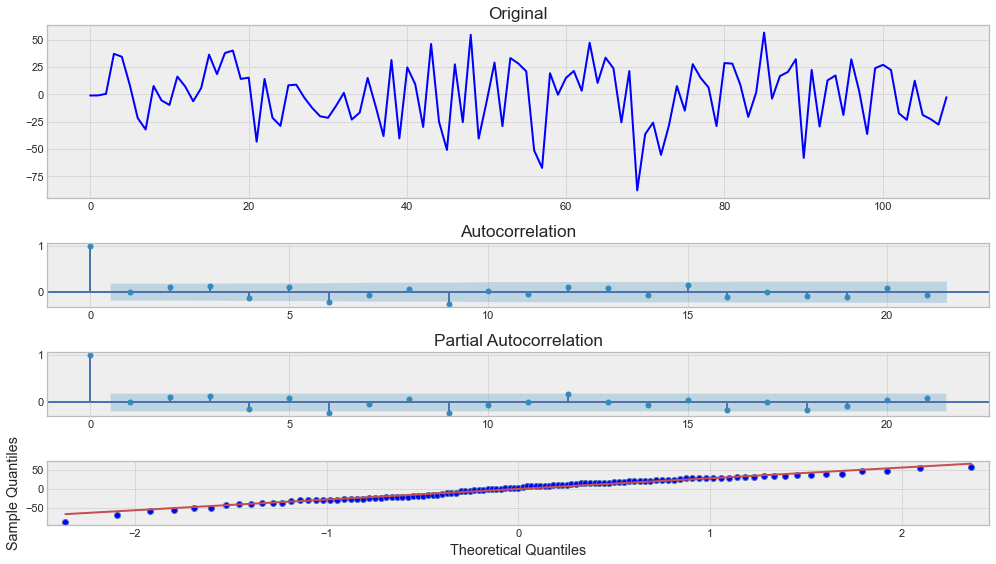

In [10]:
tsplot(res.resid)

0.046207107887426824

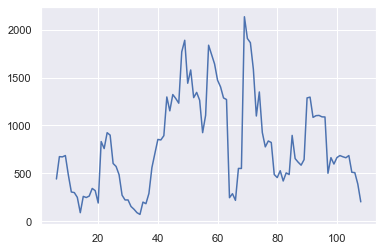

In [11]:
pd.Series(res.resid).rolling(7).var().plot()
adfuller(pd.Series(res.resid).rolling(7).var().dropna(), autolag='AIC')[1]

## Итог: 
* наверное можно говорить, что мы в какой-то мере снизили разброс дисперсии в остаточном шуме, но не сказать, что результат вау